In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


 # Exploring gene movement on the NeoX in D. psedoobscura

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns

from larval_gonad.stats import run_chisq

from IPython.display import display
import os

try:
    os.chdir(os.path.join(os.getcwd(), "notebook"))
    print(os.getcwd())
except:
    pass


/home/fearjm/Projects/larval_gonad/notebook


In [2]:
# Globals
GONIA_VS_CYTES = "../output/seurat3-cluster-wf/combined_n3_gonia_vs_cytes.feather"
MULLER = "../output/neox-wf/muller_arm_assignment.feather"
MULLER_A = "../output/neox-wf/muller_A.feather"
MULLER_D = "../output/neox-wf/muller_D.feather"
MULLER_E = "../output/neox-wf/muller_E.feather"

ORDER = ["conserved", "moved_on", "gene_death", "moved_off"]
BOXPLOT_DEFAULTS = {"order": ORDER, "notch": True, "showfliers": False}

In [3]:
# Helper Functions
def plot(x, y, data, **kwargs):
    ax = sns.boxplot(x, y, data=df, **kwargs)
    sns.swarmplot(x, y, data=df, order=ORDER, color="k", size=4)
    ax.set(
        xlabel="Evolutionary Status\n(D. pseudoobscura)",
        ylabel="Percent Cells with Expression\n(Spermatocytes)",
        title=f"{x.replace('_', ' ').title()}\nSpermatocyte Expression vs Evolutionary Status",
    )
    return ax


def run_mann(df, col):
    selection_pcts = (
        df.assign(
            muller=lambda x: x[col].replace(
                {
                    "conserved": "Selection Favor",
                    "moved_on": "Selection Favor",
                    "gene_death": "Selection Against",
                    "moved_off": "Selection Against",
                    "other": np.nan,
                }
            )
        )
        .pipe(lambda x: x[x.muller.notna()])
        .pivot(columns="muller", values="pct.2")
    )

    return mannwhitneyu(
        selection_pcts.loc[:, "Selection Favor"],
        selection_pcts.loc[:, "Selection Against"],
        alternative="two-sided",
    )



In [4]:
# Import Spermatogonia vs Spermatocyte Differential Expression
deg = pd.read_feather(GONIA_VS_CYTES).set_index("FBgn").assign(bias="NS")
deg.loc[(deg.p_val_adj <= 0.01) & (deg.avg_logFC > 0), "bias"] = "gonia"
deg.loc[(deg.p_val_adj <= 0.01) & (deg.avg_logFC < 0), "bias"] = "cyte"


In [5]:
# Merge Muller arm information to DEG.
df = deg.join(
    pd.concat(
        [
            pd.read_feather(MULLER_A)
            .set_index("FBgn")
            .squeeze()
            .replace({"recent_conserved": "conserved"}),
            pd.read_feather(MULLER_D)
            .set_index("FBgn")
            .squeeze()
            .replace({"recent_conserved": "conserved"}),
            pd.read_feather(MULLER_E)
            .set_index("FBgn")
            .squeeze()
            .replace({"recent_conserved": "conserved"}),
        ],
        axis=1,
        sort=True,
    ),
    how="inner",
    sort=True,
)


 ## Muller A

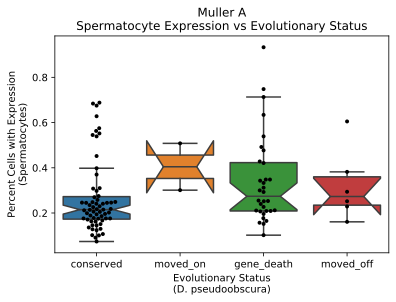

In [6]:
# Plot percent of cells with cyte expression vs evolutionary status
plot("muller_A", "pct.2", df, **BOXPLOT_DEFAULTS)


In [7]:
# Cross tabulation 1: all groups
ct_full = pd.crosstab(df.bias, df.muller_A.replace({"other": np.nan}))
ct_full.reindex(ORDER, axis=1).fillna(0)


muller_A,conserved,moved_on,gene_death,moved_off
bias,,,,
NS,0,1,4,1
cyte,1,1,9,1
gonia,62,0,19,4


In [8]:
# Chi-Square: all groups
run_chisq(ct_full).loc[
    (slice(None), ["observed", "expected", "adj std residual", "flag_sig"]), :
].reindex(ORDER, axis=1).dropna(how="all", axis=1)


𝛘^2: 35.4513, p-value: 0.0000, df: 6


muller_A                conserved  moved_on  gene_death  moved_off
bias  type                                                        
NS    observed             0.0000    1.0000      4.0000     1.0000
      expected             3.6699    0.1165      1.8641     0.3495
      adj std residual    -3.1677    2.6935      1.9417     1.1683
      flag_sig             1.0000    1.0000      0.0000     0.0000
cyte  observed             1.0000    1.0000      9.0000     1.0000
      expected             7.3398    0.2330      3.7282     0.6990
      adj std residual    -3.9950    1.7071      3.4987     0.3946
      flag_sig             1.0000    0.0000      1.0000     0.0000
gonia observed            62.0000    0.0000     19.0000     4.0000
      expected            51.9903    1.6505     26.4078     4.9515
      adj std residual     5.3288   -3.1035     -4.1533    -1.0540
      flag_sig             1.0000    1.0000      1.0000     0.0000

In [9]:
# Cross tabulation 2: collapsed groups
ct_collapsed = pd.crosstab(
    df.bias.replace({"NS": "Not Biased", "gonia": "Not Biased", "cyte": "Cyte Biased"}),
    df.muller_A.replace(
        {
            "conserved": "Selection Favor",
            "moved_on": "Selection Favor",
            "gene_death": "Selection Against",
            "moved_off": "Selection Against",
            "other": np.nan,
        }
    ),
)
ct_collapsed[["Selection Favor", "Selection Against"]]


muller_A,Selection Favor,Selection Against
bias,,
Cyte Biased,2,10
Not Biased,63,28


In [10]:
# Chi-Square: collapsed groups
run_chisq(ct_collapsed)[["Selection Favor", "Selection Against"]]


𝛘^2: 10.4253, p-value: 0.0012, df: 1


muller_A                      Selection Favor  Selection Against
bias        type                                                
Cyte Biased observed                   2.0000            10.0000
            expected                   7.5728             4.4272
            residual                  -5.5728             5.5728
            adj std residual          -3.5471             3.5471
            X^2                        4.1010             7.0149
            fdr q-value                0.0007             0.0007
            flag_sig                   1.0000             1.0000
Not Biased  observed                  63.0000            28.0000
            expected                  57.4272            33.5728
            residual                   5.5728            -5.5728
            adj std residual           3.5471            -3.5471
            X^2                        0.5408             0.9250
            fdr q-value                0.0007             0.0007
            flag_sig                   1.0000             1.0000

In [11]:
# Fun Mann Whitney U test for distribution medians (Favor vs Against)
run_mann(df, "muller_A")


MannwhitneyuResult(statistic=3440.0, pvalue=1.3168422149384958e-05)

 ## Muller D

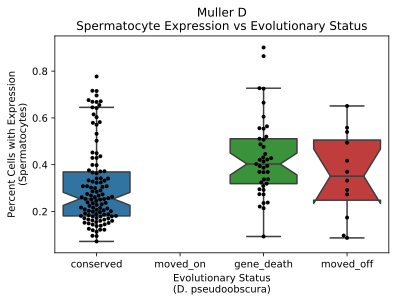

In [12]:
# Plot percent of cells with cyte expression vs evolutionary status
plot("muller_D", "pct.2", df, **BOXPLOT_DEFAULTS)


In [13]:
# Cross tabulation 1: all groups
ct_full = pd.crosstab(df.bias, df.muller_D.replace({"other": np.nan}))
ct_full.reindex(ORDER, axis=1).fillna(0)


muller_D,conserved,moved_on,gene_death,moved_off
bias,,,,
NS,8,0.0,7,1
cyte,17,0.0,27,7
gonia,86,0.0,7,4


In [14]:
# Chi-Square: all groups
run_chisq(ct_full).loc[
    (slice(None), ["observed", "expected", "adj std residual", "flag_sig"]), :
].reindex(ORDER, axis=1).dropna(how="all", axis=1)


𝛘^2: 50.6224, p-value: 0.0000, df: 4


muller_D                conserved  gene_death  moved_off
bias  type                                              
NS    observed             8.0000      7.0000     1.0000
      expected            10.8293      4.0000     1.1707
      adj std residual    -1.5920      1.8233    -0.1725
      flag_sig             0.0000      0.0000     0.0000
cyte  observed            17.0000     27.0000     7.0000
      expected            34.5183     12.7500     3.7317
      adj std residual    -6.3188      5.5515     2.1171
      flag_sig             1.0000      1.0000     0.0000
gonia observed            86.0000      7.0000     4.0000
      expected            65.6524     24.2500     7.0976
      adj std residual     6.9112     -6.3283    -1.8895
      flag_sig             1.0000      1.0000     0.0000

In [15]:
# Cross tabulation 2: collapsed groups
ct_collapsed = pd.crosstab(
    df.bias.replace({"NS": "Not Biased", "gonia": "Not Biased", "cyte": "Cyte Biased"}),
    df.muller_D.replace(
        {
            "conserved": "Selection Favor",
            "moved_on": "Selection Favor",
            "gene_death": "Selection Against",
            "moved_off": "Selection Against",
            "other": np.nan,
        }
    ),
)
ct_collapsed[["Selection Favor", "Selection Against"]]


muller_D,Selection Favor,Selection Against
bias,,
Cyte Biased,17,34
Not Biased,94,19


In [16]:
# Chi-Square: collapsed groups
run_chisq(ct_collapsed)[["Selection Favor", "Selection Against"]]


𝛘^2: 37.6804, p-value: 0.0000, df: 1


muller_D                      Selection Favor  Selection Against
bias        type                                                
Cyte Biased observed                  17.0000            34.0000
            expected                  34.5183            16.4817
            residual                 -17.5183            17.5183
            adj std residual          -6.3188             6.3188
            X^2                        8.8907            18.6201
            fdr q-value                0.0000             0.0000
            flag_sig                   1.0000             1.0000
Not Biased  observed                  94.0000            19.0000
            expected                  76.4817            36.5183
            residual                  17.5183           -17.5183
            adj std residual           6.3188            -6.3188
            X^2                        4.0126             8.4037
            fdr q-value                0.0000             0.0000
            flag_sig                   1.0000             1.0000

In [17]:
# Fun Mann Whitney U test for distribution medians (Favor vs Against)
run_mann(df, "muller_D")


MannwhitneyuResult(statistic=7512.0, pvalue=4.77697285047034e-12)

 ## Muller E

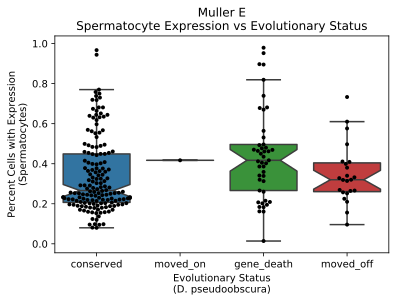

In [18]:
# Plot percent of cells with cyte expression vs evolutionary status
plot("muller_E", "pct.2", df, **BOXPLOT_DEFAULTS)


In [19]:
# Cross tabulation 1: all groups
ct_full = pd.crosstab(df.bias, df.muller_E.replace({"other": np.nan}))
ct_full.reindex(ORDER, axis=1).fillna(0)


muller_E,conserved,moved_on,gene_death,moved_off
bias,,,,
NS,13,0,5,2
cyte,28,1,28,10
gonia,117,0,12,11


In [20]:
# Chi-Square: all groups
run_chisq(ct_full).loc[
    (slice(None), ["observed", "expected", "adj std residual", "flag_sig"]), :
].reindex(ORDER, axis=1).dropna(how="all", axis=1)


𝛘^2: 41.5756, p-value: 0.0000, df: 6


muller_E                conserved  moved_on  gene_death  moved_off
bias  type                                                        
NS    observed            13.0000    0.0000      5.0000     2.0000
      expected            13.9207    0.0881      3.9648     2.0264
      adj std residual    -0.4687   -0.3115      0.6080    -0.0205
      flag_sig             0.0000    0.0000      0.0000     0.0000
cyte  observed            28.0000    1.0000     28.0000    10.0000
      expected            46.6344    0.2952     13.2819     6.7885
      adj std residual    -5.8953    1.5487      5.3722     1.5487
      flag_sig             1.0000    0.0000      1.0000     0.0000
gonia observed           117.0000    0.0000     12.0000    11.0000
      expected            97.4449    0.6167     27.7533    14.1850
      adj std residual     5.8039   -1.2713     -5.3944    -1.4409
      flag_sig             1.0000    0.0000      1.0000     0.0000

In [21]:
# Cross tabulation 2: collapsed groups
ct_collapsed = pd.crosstab(
    df.bias.replace({"NS": "Not Biased", "gonia": "Not Biased", "cyte": "Cyte Biased"}),
    df.muller_E.replace(
        {
            "conserved": "Selection Favor",
            "moved_on": "Selection Favor",
            "gene_death": "Selection Against",
            "moved_off": "Selection Against",
            "other": np.nan,
        }
    ),
)
ct_collapsed[["Selection Favor", "Selection Against"]]


muller_E,Selection Favor,Selection Against
bias,,
Cyte Biased,29,38
Not Biased,130,30


In [22]:
# Chi-Square: collapsed groups
run_chisq(ct_collapsed)[["Selection Favor", "Selection Against"]]


𝛘^2: 30.6583, p-value: 0.0000, df: 1


muller_E                      Selection Favor  Selection Against
bias        type                                                
Cyte Biased observed                  29.0000            38.0000
            expected                  46.9295            20.0705
            residual                 -17.9295            17.9295
            adj std residual          -5.6958             5.6958
            X^2                        6.8500            16.0169
            fdr q-value                0.0000             0.0000
            flag_sig                   1.0000             1.0000
Not Biased  observed                 130.0000            30.0000
            expected                 112.0705            47.9295
            residual                  17.9295           -17.9295
            adj std residual           5.6958            -5.6958
            X^2                        2.8684             6.7071
            fdr q-value                0.0000             0.0000
            flag_sig                   1.0000             1.0000

In [23]:
# Fun Mann Whitney U test for distribution medians (Favor vs Against)
run_mann(df, "muller_D")

MannwhitneyuResult(statistic=7512.0, pvalue=4.77697285047034e-12)